##### Train convLSTM model using only simulation image from the gazebo 
#### Date: 2020/11/14
#### Goal of the model: To compare the results with convLSTM_GAN and CNN_GAN

In [1]:
!nvidia-smi
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2
sys.path.append('/opt/ros/kinetic/lib/python2.7/dist-packages')

import numpy as np
import matplotlib.pyplot as plt
import os
import random
import keras
import tensorflow as tf
import copy
import keras.backend as K

from PIL import Image                              
from keras import optimizers, losses, metrics, models
from keras.models import load_model
from keras.utils import to_categorical
from models.cnn_model_LSTM_many_to_one import cnn_lstm  
from keras.utils.training_utils import multi_gpu_model

Sun Aug 22 19:41:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:05:00.0  On |                  N/A |
| 50%   51C    P0    94W / 250W |    242MiB / 11018MiB |     40%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:06:00.0 Off |                  N/A |
| 35%   

Using TensorFlow backend.


In [ ]:
# load data
root_path = '/data/data_2021_08_18/preprocessed/SIM_CONVLSTM_DATA'
img_dir = root_path + '/train_image_ConvLSTM_2021_08_18_2.npy'
label_dir = root_path + '/train_label_ConvLSTM_2021_08_18_2.npy'
# Allocate variable for train_x and train_y
img_x = np.load(img_dir)
label = np.load(label_dir)

In [ ]:
"Adding Gaussian noise"
# train_x = np.zeros([len(img_x), 6, 120, 160, 1])
# # Reshape the train images
# for i in range(len(img_x)):
#     temp_img = np.rollaxis(img_x[i], 2, 0)
#     temp_img = np.reshape(temp_img, [6, 120, 160, 1])
#     temp_img = temp_img / 255.
#     train_x[i] = Add_gussian_noise(temp_img)    

In [ ]:
# Shuffle the data
print("Number of data:{}".format(len(img_x)))
rand_index = np.random.permutation(len(label))
train_x = img_x[rand_index]
label = label[rand_index]

In [ ]:
# Check the label
n = np.arange(len(train_x))
plt.figure(figsize = (16,9))
plt.scatter(n, label[n])
print(np.sum(label<6))
# plt.ylim([0,1.5])
plt.show()

In [ ]:
# visualization of training data
n = np.random.randint(len(train_x))
print("True time to collision: {}".format(label[n]))

sample = train_x[n]
print("Shape of the data:{}".format(np.shape(sample)))
sample_y = label[n]
fig = plt.figure(figsize = (10,8))
for i in range(6):
    _sample = np.reshape(sample[i,:],[128, 128,3])
    ax = fig.add_subplot(2,3,i+1)
    ax.imshow(_sample)
    ax.set_title('time step:' + str(i))
    ax.axis("off")

plt.subplots_adjust(wspace=0.02, hspace=0)
plt.show()

# fig.savefig('sample_input.png', dpi = 600, bbox_inches = 'tight')

In [ ]:
# data split for train, validation, and test

n = np.int(len(train_x)* 0.80)
m = np.int(len(label)*0.97)

# train 
train_img = train_x[:n] 
train_y = label[:n]

# validation
valid_img = train_x[n:m]
valid_y = label[n:m]

# test
test_img = train_x[m:] 
test_y = label[m:]

#check size
print("Training data size: {}".format(np.shape(train_img)))
print("Training y size: {}".format(np.shape(train_y)))
print("Validation data size: {}".format(np.shape(valid_img)))
print("Test data size: {}".format(np.shape(test_img)))

In [ ]:
del train_x
del label

In [ ]:
# visualization of training data
n = np.random.randint(len(train_img))
print("True time to collision: {}".format(train_y[n]))

sample = train_img[n]
print("Shape of the data:{}".format(np.shape(sample)))
sample_y = train_y[n]
fig = plt.figure(figsize = (10,8))
for i in range(6):
    _sample = np.reshape(sample[i,:],[128, 128,3])
    ax = fig.add_subplot(2,3,i+1)
    ax.imshow(_sample)
    ax.set_title('time step:' + str(i))
    ax.axis("off")

plt.subplots_adjust(wspace=0.02, hspace=0)
plt.show()

In [2]:
def getModel(img_width, img_height, img_channel, num_frames, output_dim,num_actions, model_path):
    model = cnn_lstm(img_width, img_height, img_channel, num_frames, output_dim, num_actions)
    
    if model_path:
        try:
            model.load_weights(model_path)
            print("Loaded model from {}".format(model_path))
        
        except:
            print("Impossible to find weight path. Train new model.")
    return model

In [3]:
def mean_loss(log_var, mean):
    def customLoss(yTrue, yPred):
        loss1 = K.exp(-log_var) * K.square(K.abs(yTrue - mean))
        return loss1
    return customLoss
    
def var_loss(log_var):
    def customLoss(yTrue, yPred):
        loss2 = log_var
        return loss2
    return customLoss

In [4]:
# define model and optimizer
# est_coll_model = getModel(128, 128, 3, 6, 1,8,  'None')
est_coll_model = multi_gpu_model(getModel(128, 128, 3, 6, 1,8,  'None'), gpus=2)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 6, 128, 128,  0                                            
__________________________________________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)     (None, 6, 64, 64, 32 112128      input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 6, 64, 64, 32 128         conv_lst_m2d_1[0][0]             
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 6, 64, 64, 32 0        

In [ ]:
var_layer = est_coll_model.get_layer('variance').output
mean_layer = est_coll_model.get_layer('mean').output
opti = optimizers.Adam(lr= 1e-6, decay = 1e-5)
est_coll_model.compile(optimizer= opti, loss = [mean_loss(var_layer, mean_layer), var_loss(var_layer)], loss_weights = [0.5, 0.5])

In [ ]:
callbacks_list = [    
    keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience= 50,
    ),
    keras.callbacks.TensorBoard(
    log_dir = 'log_dir/2021_08_18_GAN_model/ConvLSTM_sim_image_2',
    histogram_freq=1,),
    keras.callbacks.ModelCheckpoint(
        filepath='./cnn_saved_models/2021_08_18_GAN_model/ConvLSTM_sim_image_2.h5',
        save_best_only=True,
        save_weights_only=True,
        verbose=1)    
]

In [ ]:
history = est_coll_model.fit(train_img, [train_y, train_y],
                             validation_data=[valid_img ,[valid_y, valid_y]],
                             epochs=200,
                             batch_size=32,
                             callbacks = callbacks_list,
                            initial_epoch= 0)

In [ ]:
# Check the performance of the proposed model
import time
error_matrix = []
for j in range(100):
    st = time.time()
    sample = test_img[j]
    _sample_img = np.reshape(sample, [-1, 6, 128, 128, 3])
    
    y_eval = []
    aleatoric = []
    epistemic = [] 
    
    for i in range(5):   
        temp_input = np.reshape(test_img[j], [-1, 6, 128, 128, 3])    
        _mean, _var = est_coll_model.predict(temp_input)    
        y_eval.append(_mean)    
        epistemic.append(_mean)
        aleatoric.append(_var)   

    epistemic_uncertainty = np.sqrt(np.var(epistemic))
    aleatoric_uncertainty = np.sqrt(np.mean((np.exp(aleatoric))))
    total_uncertainty = epistemic_uncertainty + aleatoric_uncertainty
    y_eval = np.mean(y_eval)
            
    sample = test_img[j]
    sample_y = test_y[j]
    error_matrix.append(np.abs(sample_y - y_eval))    

    fig = plt.figure(figsize = (10,8))
    for i in range(6):
        _sample = np.reshape(sample[0,:],[128, 128,3])
        ax = fig.add_subplot(2,3,i+1)
        ax.imshow(_sample)
        ax.set_title('time step:' + str(i))
        ax.axis("off")

    plt.subplots_adjust(wspace=0.02, hspace=0)
    plt.show()
    
    plt.figure()
    plt.vlines(sample_y,ymin=0, ymax=6, color = 'r', label='true')
    plt.vlines(y_eval, ymin=0,ymax=6, color='b', label='estimate')
    plt.axvspan(y_eval - aleatoric_uncertainty, y_eval + aleatoric_uncertainty, ymin=0, ymax=6, color='green', alpha=0.3, label = 'aleatoric')
    plt.axvspan(y_eval - epistemic_uncertainty, y_eval + epistemic_uncertainty, ymin=0, ymax=6, color='blue', alpha=0.3, label = 'epistemic')
    plt.axvspan(y_eval - total_uncertainty, y_eval + total_uncertainty, ymin=0, ymax=6, color='grey', alpha=0.6, label = 'total uncertainty')
    plt.xlim([0,6])
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
print('Total error:{}'.format(np.mean(error_matrix)))

In [5]:
# # load_model
est_coll_model.load_weights('./cnn_saved_models/2021_08_18_GAN_model/ConvLSTM_sim_image_2.h5')

### Check 20 episode of parrot experiments
- Approximate velocity of the parrot: 0.2m/s (Gazebo model velocity: 0.5m/s)

In [6]:
total_error = []

0


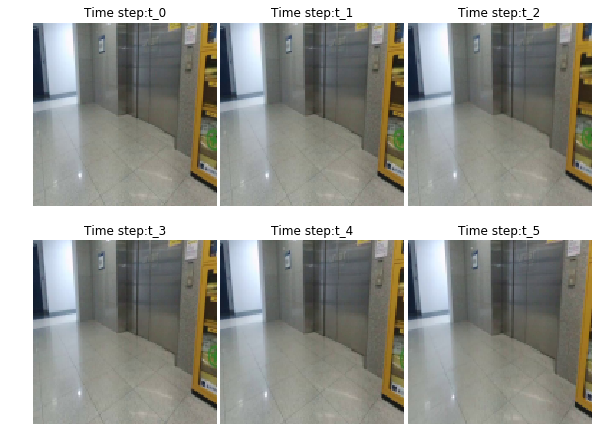

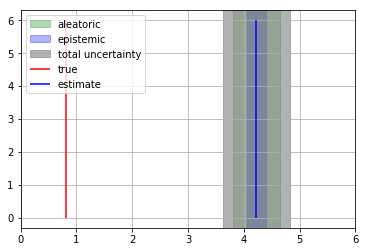

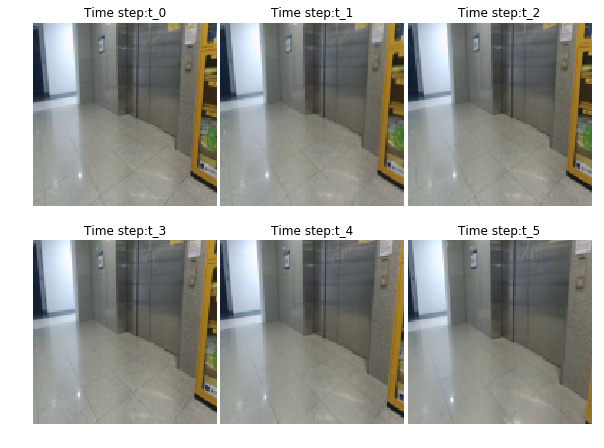

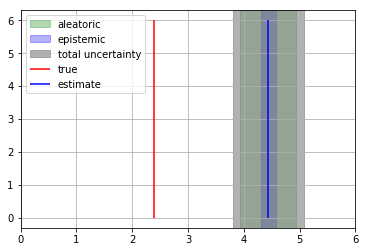

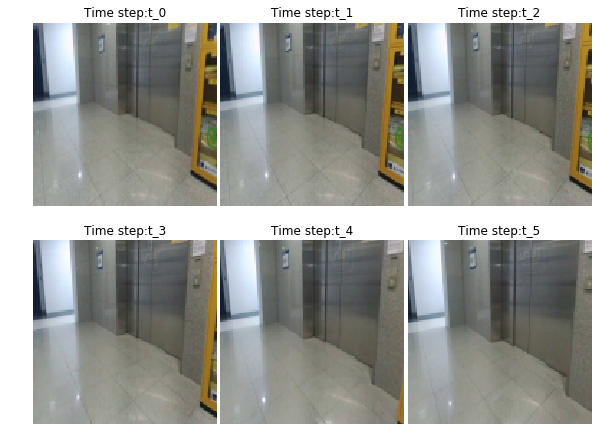

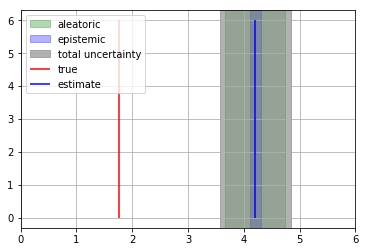

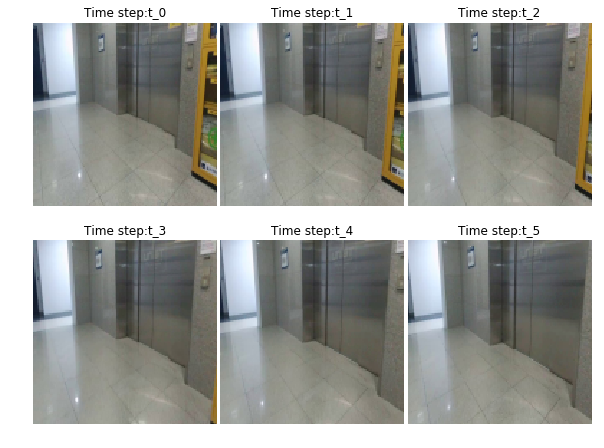

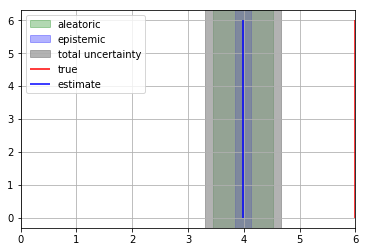

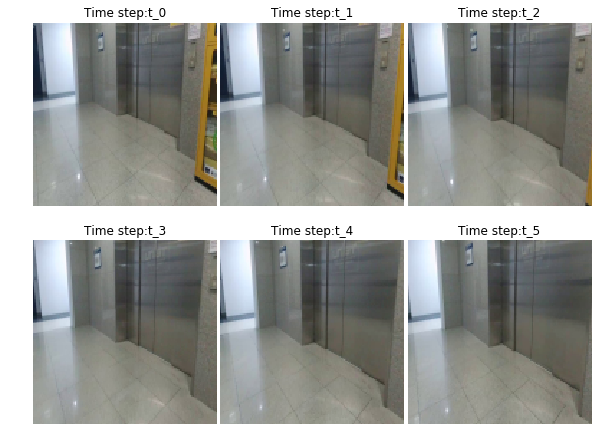

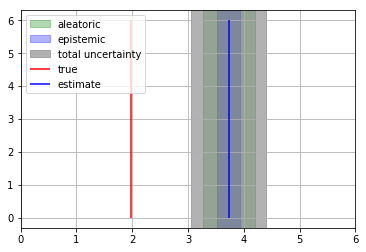

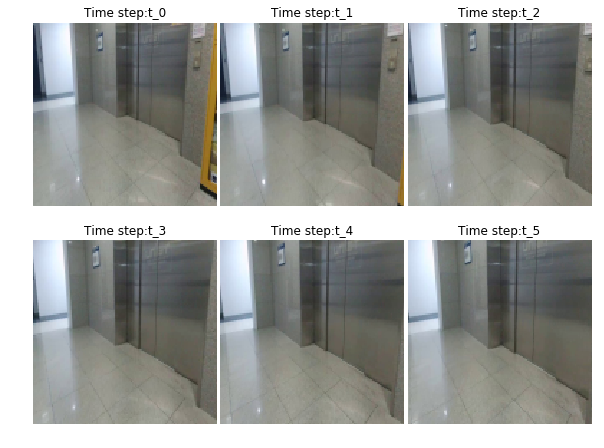

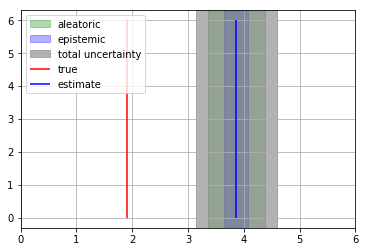

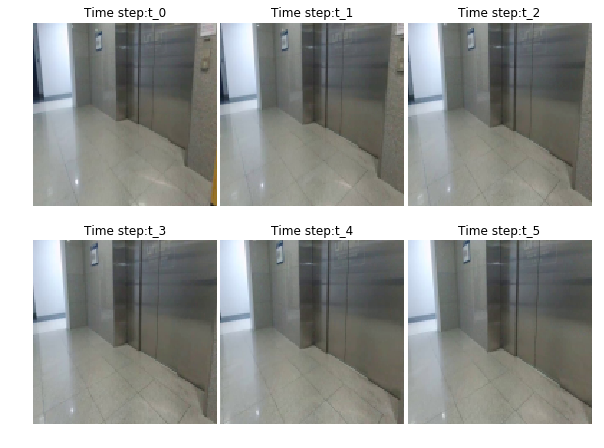

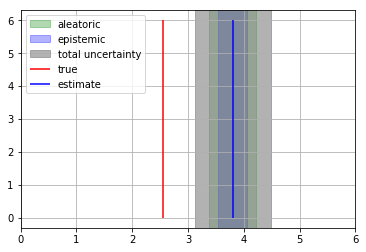

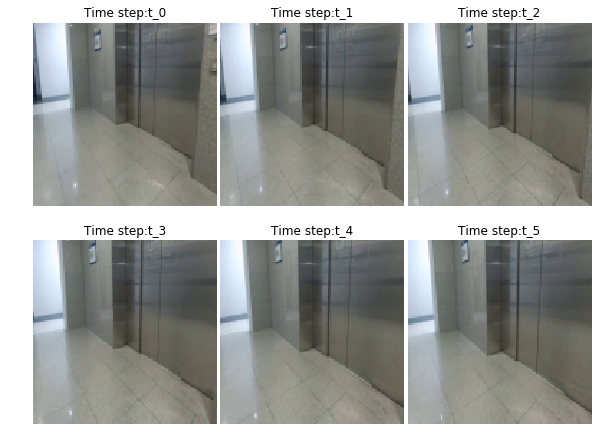

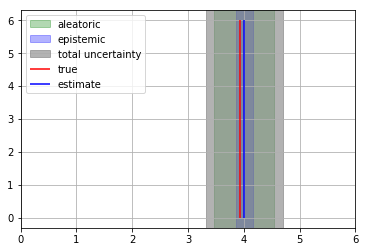

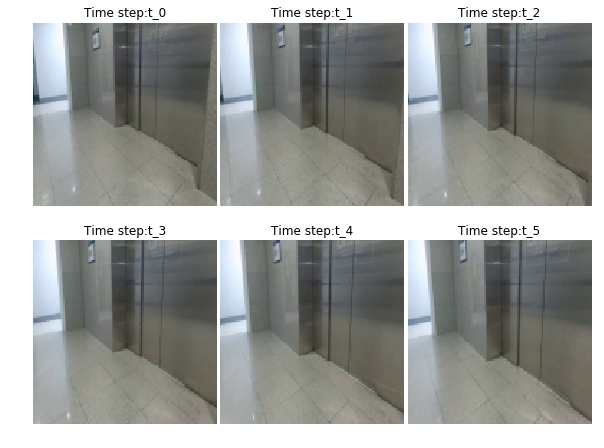

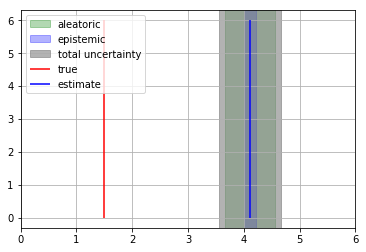

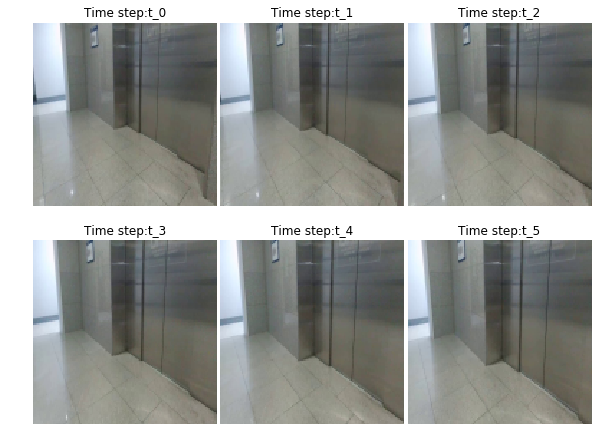

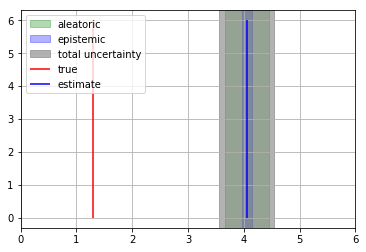

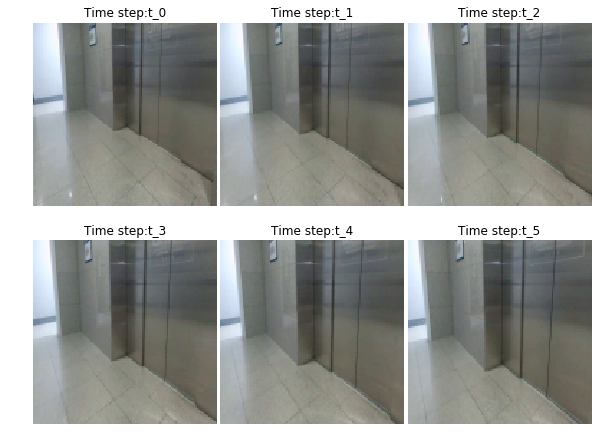

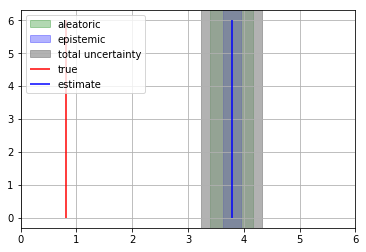

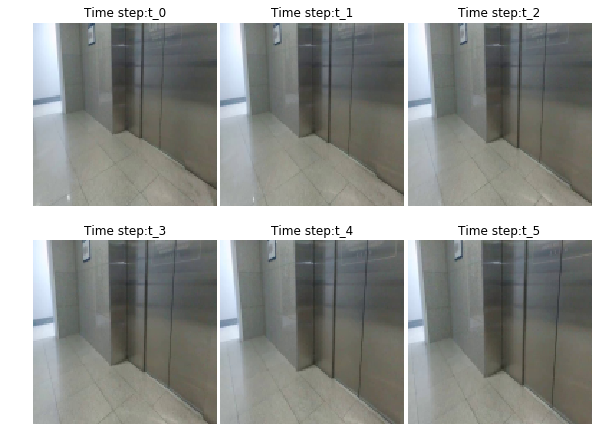

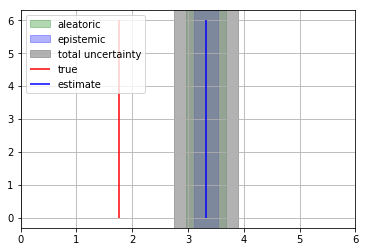

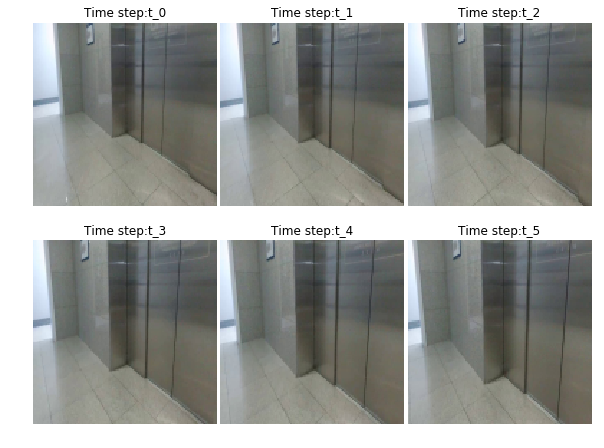

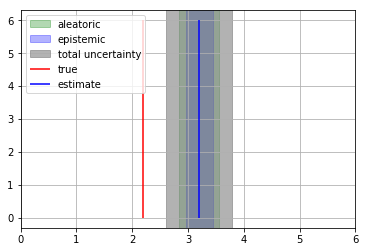

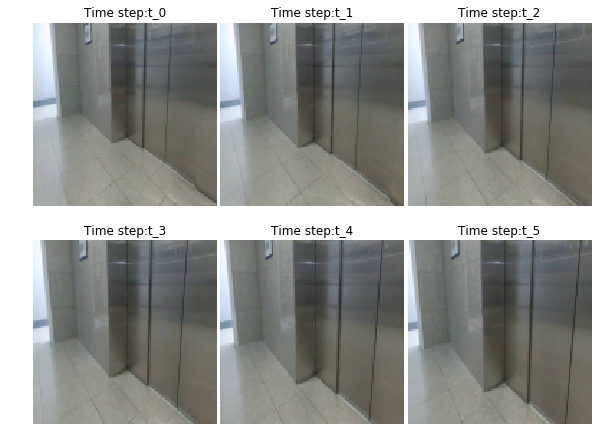

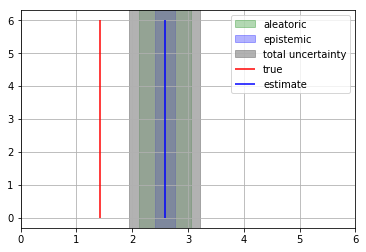

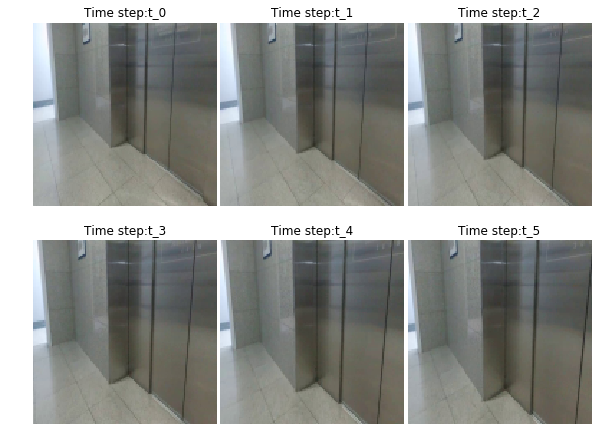

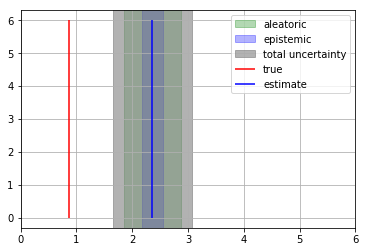

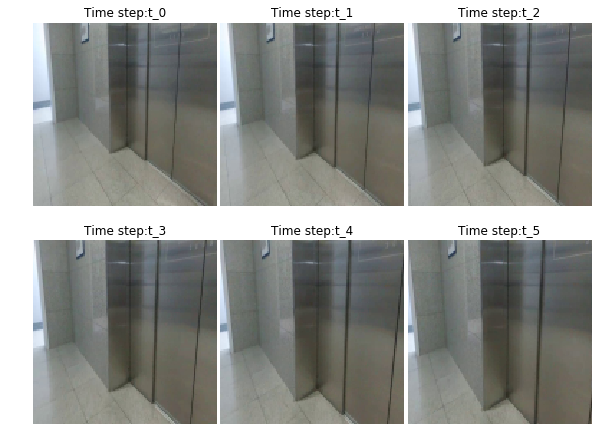

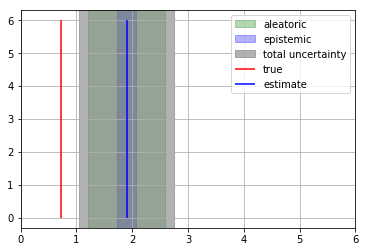

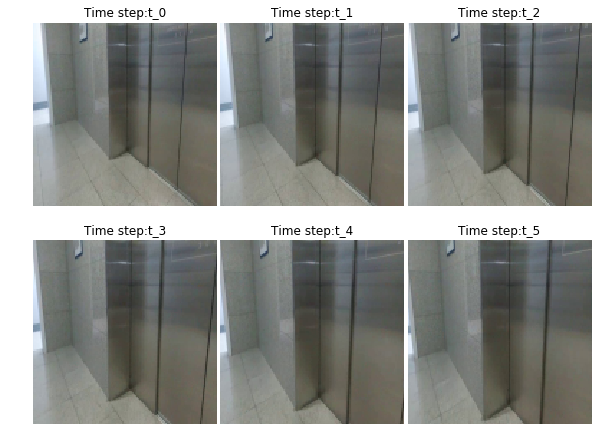

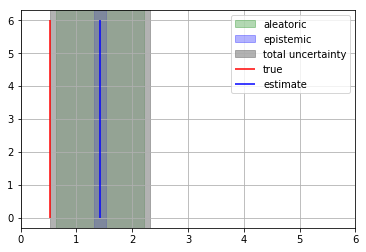

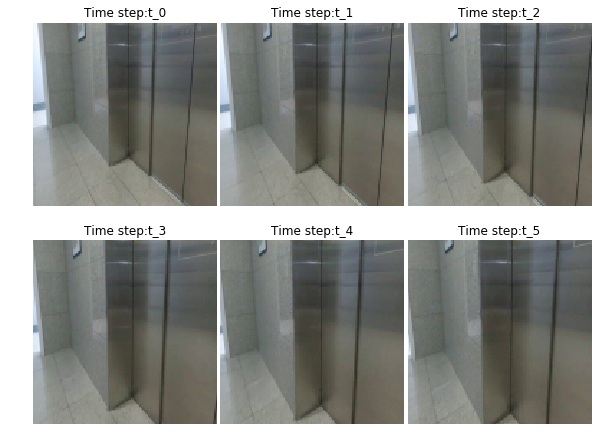

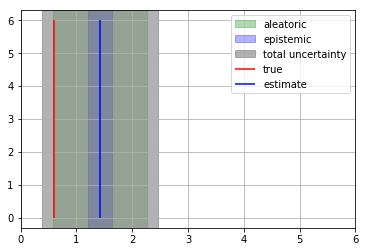

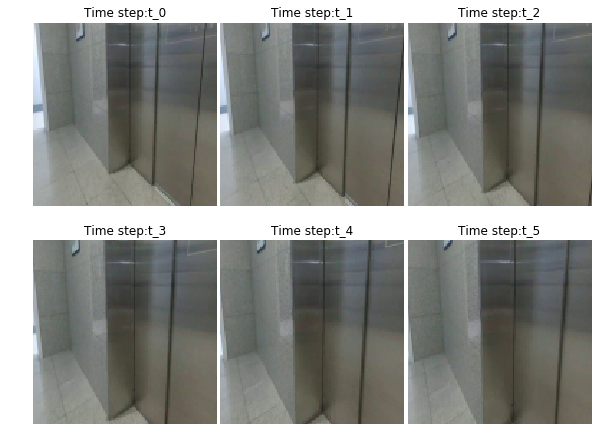

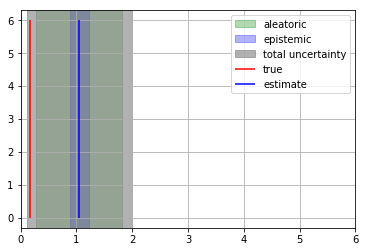

Total_error:1.6978189391801932
Error variance:0.7027764297272663
Uncertainty:0.6920034289360046


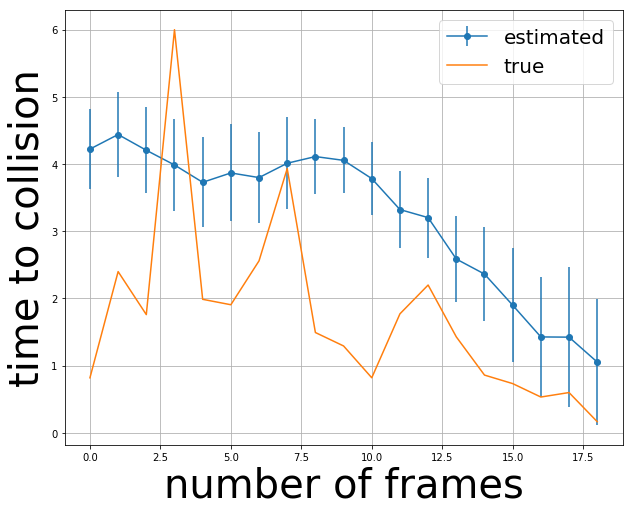

1.6978189391801932
0.0


In [7]:
for episode in range(1):
    print(episode)
    
    # Check the model performance using totally unseen data
#     root_path = '/home/asl/machine_learning/time_to_collision/Preprocessed_data/Parrot_data/image_new'
    root_path = './data_collection/real_test_images/preprocessed'
    new_img_dir = root_path + '/episode_0/image.npy'    
    new_label_dir = root_path + '/ttc/distance_0.npy'
    new_velocity_dir = root_path + '/velocity/velocity_0.npy'

    # Allocate variable for train_x and train_y
    new_test_img = np.load(new_img_dir)
    new_test_y = np.load(new_label_dir)
    new_velocity_y = np.load(new_velocity_dir)        

    # For visualizing t2c values    
    true_label = []
    estimated_label = []  
    
    # visualization of training data
    error_matrix = []
    uncertainty_matrix = []

    for j in range(len(new_test_img)):
        sample = new_test_img[j]    
        temp_input = np.reshape(sample, [-1, 6, 128, 128, 3])

        y_eval = []
        aleatoric = []
        epistemic = []

        for i in range(5):
            _mean, _var = est_coll_model.predict(temp_input)    
            y_eval.append(_mean)    
            epistemic.append(_mean)
            aleatoric.append(_var)   

        epistemic_uncertainty = np.sqrt(np.var(epistemic))
        aleatoric_uncertainty = np.sqrt(np.mean((np.exp(aleatoric))))
        total_uncertainty = epistemic_uncertainty + aleatoric_uncertainty
        y_eval = np.mean(y_eval) 
        uncertainty_matrix.append(total_uncertainty)    

        sample = new_test_img[j]
        sample = np.reshape(sample, [6,128, 128,3])
        sample_y = new_test_y[j]
        error_matrix.append(np.abs(sample_y - y_eval))
        
        # store true and estimated values 
        true_label.append(sample_y)
        estimated_label.append(y_eval)
              
        fig = plt.figure(figsize = (10,8))
        for i in range(6):
            _sample = np.reshape(sample[i], [128, 128,3])
            ax = fig.add_subplot(2,3,i+1)
            ax.imshow(_sample)
            ax.set_title('Time step:t_' + str(i))
            ax.axis('off')
        plt.subplots_adjust(wspace=0.02, hspace=0)
        plt.show()

        plt.figure()
        plt.vlines(sample_y,ymin=0, ymax=6, color = 'r', label='true')
        plt.vlines(y_eval, ymin=0,ymax=6, color='b', label='estimate')
        plt.axvspan(y_eval - aleatoric_uncertainty, y_eval + aleatoric_uncertainty, ymin=0, ymax=6, color='green', alpha=0.3, label = 'aleatoric')
        plt.axvspan(y_eval - epistemic_uncertainty, y_eval + epistemic_uncertainty, ymin=0, ymax=6, color='blue', alpha=0.3, label = 'epistemic')
        plt.axvspan(y_eval - total_uncertainty, y_eval + total_uncertainty, ymin=0, ymax=6, color='grey', alpha=0.6, label = 'total uncertainty')
        plt.xlim([0,6])
        plt.legend()
        plt.grid()
        plt.show()
    
    total_error.append(np.mean(error_matrix))
    print("Total_error:{}".format(np.mean(error_matrix)))
    print("Error variance:{}".format(np.var(error_matrix)))
    print("Uncertainty:{}".format(np.mean(uncertainty_matrix)))
    
    fig2 = plt.figure(figsize=(10,8))
    plt.errorbar(np.arange(len(estimated_label)), estimated_label, yerr = uncertainty_matrix, marker = 'o', label = 'estimated')
    plt.errorbar(np.arange(len(true_label)), true_label, label = 'true')
    plt.legend(fontsize = '20')
    plt.grid()
    plt.ylabel('time to collision', fontsize = '40')
    plt.xlabel('number of frames', fontsize = '40')
    plt.show()
#     fig2.savefig('./experiment_results' + str(episode) + '.png', dpi = 600, bbox_inches = 'tight')
    
print(np.mean(total_error))
print(np.std(total_error))